In [58]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [60]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [4]:
# Decribing the data that has been provided using Pandas functions
# Save to df
data=pd.read_csv('data/vehicles.csv')

# Shape and preview
print('Vehicles Data Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()

Vehicles Data Shape : (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [6]:
#There seems to be mistakes in the data:
# 1. price of vehicles as we can see the maximum is 373 Million dollars which is very unlikely. 
# 2. vehicle with 0 price and 0 odometer looks wrong. We will explore outliers and how to address them later on in the process.


In [7]:
# Exploring the data, lets start by describing the dataframe to get a list of provided attributes/features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [8]:
# number of unique answers for each feature
unique = data.nunique(axis = 0)
unique

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [9]:
#Check the number of Null Columns
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [10]:
# convert it into a percentage
data.isnull().sum()/data.shape[0]*100

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

##### Lot of data is missing for - Size (72%), Cylinders (42%), Condition (41%), VIN (38%), Drive (31%), Paint_color (31%) and type (22%)

## Data Preparation
##### After understanding the data and metrics, it is time to prpepare the final dataset for modeling. This will include handing data issues and cleaning of the original dataset.

In [11]:
# Review the correlation of the dataset with the missing values
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

In [12]:
numeric_data.corr()

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


In [13]:
# It shows that there is weak correlation between the price, year and odometer. 
# Id is irrelevant for this analysis. Value in ID column looks like unique inventory number
# We could remove id column from the dataset to see if it makes a difference
data1 = numeric_data.drop('id', axis=1)
data1.corr()

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


### A. Price and Odometer Outliers

In [14]:
# Results are skewed as there are many null values. Also, as these are used cars, there should be a value for the odometer but 
# you could explain price of $0 as a situation where the vehicle has not been evaluated and priced for the dataset.

In [15]:
#drop rows that has a). price less than 0.   b). Null resords where price more than 0 
data = data.query("price > 0").dropna()
data

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32496 entries, 215 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            32496 non-null  int64  
 1   region        32496 non-null  object 
 2   price         32496 non-null  int64  
 3   year          32496 non-null  float64
 4   manufacturer  32496 non-null  object 
 5   model         32496 non-null  object 
 6   condition     32496 non-null  object 
 7   cylinders     32496 non-null  object 
 8   fuel          32496 non-null  object 
 9   odometer      32496 non-null  float64
 10  title_status  32496 non-null  object 
 11  transmission  32496 non-null  object 
 12  VIN           32496 non-null  object 
 13  drive         32496 non-null  object 
 14  size          32496 non-null  object 
 15  type          32496 non-null  object 
 16  paint_color   32496 non-null  object 
 17  state         32496 non-null  object 
dtypes: float64(2), int64(2), obj

In [17]:
data.select_dtypes(include=[np.number]).corr()

,id,price,year,odometer
id,1.000000,-0.067544,-0.064472,0.025715
price,-0.067544,1.000000,0.315430,-0.233358
year,-0.064472,0.315430,1.000000,-0.210172
odometer,0.025715,-0.233358,-0.210172,1.000000


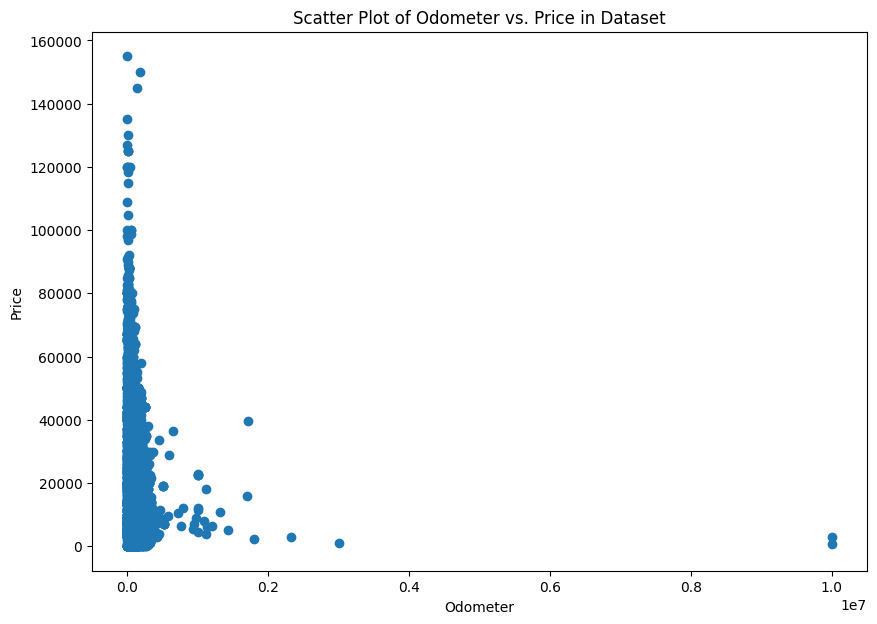

In [18]:
# Let's try a scatter plot of price vs odomoter to see if there is a Trend. Usually the lower the odometer, the higher the car price

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(data['odometer'], data['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

In [19]:
# data is still skewed towards very low values, odometer has outlier values in Millions.
# min and max values of odometer and price based on current record selection are:
print("Minimum Price of cars: ", data['price'].min())
print("Maximum Price of cars: ", data['price'].max())
print("Minimum Odometer on cars: ", data['odometer'].min())
print("Maximum Odometer on cars: ", data['odometer'].max())

Minimum Price of cars:  1
Maximum Price of cars:  155000
Minimum Odometer on cars:  0.0
Maximum Odometer on cars:  9999999.0


In [20]:
# Removing records with zero for Odometer, price > $100K , ododmeter > 1.5M as these are the outliers skewing the dataset visualization.
data.drop(data[data['odometer'] == 0].index, inplace = True)
data.drop(data[data['odometer'] > 1500000].index, inplace = True)
data.drop(data[data['price'] > 100000].index, inplace = True)
data

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


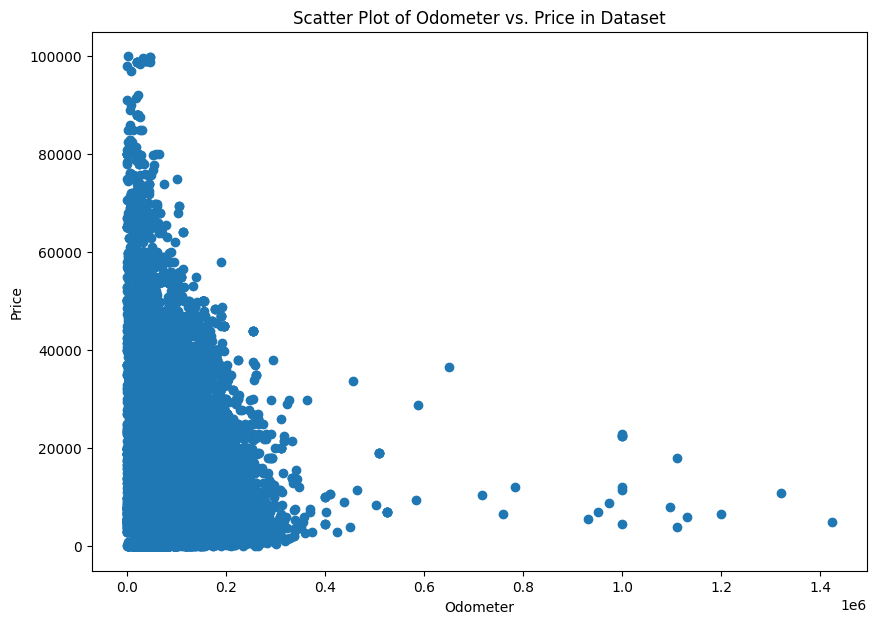

In [21]:
# Let's try a scatter plot of price vs odomoter to see if there is a Trend. Usually the lower the odometer, the higher the car price

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(data['odometer'], data['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

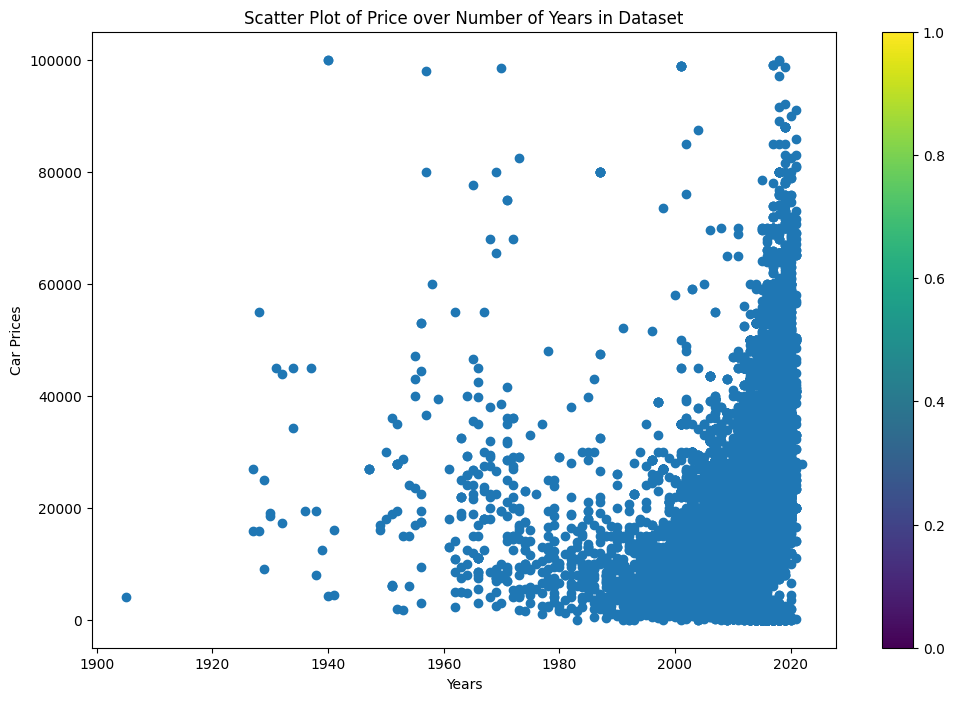

In [22]:
# Scatter plot of year of manufacture vs car price
plt.figure(figsize=(12,8))
plt.scatter(data['year'], data['price'])
 
# Adding Title to the Plot
plt.title("Scatter Plot of Price over Number of Years in Dataset")
 
# Setting the X and Y labels
plt.xlabel('Years')
plt.ylabel('Car Prices')
plt.colorbar()
 
plt.show()

In [23]:
data.shape

(32408, 18)

In [24]:
# Reviewing the records, we can state that id and VIN are not useful for predicting the car price
# Attributes region and state are also duplicates. We can remove one for now. 
data = data.drop(columns=['id','VIN','region'], axis=1)

In [25]:
data.shape

(32408, 15)

In [26]:
unique = data.nunique(axis = 0)
unique

price            3117
year               88
manufacturer       41
model            4932
condition           6
cylinders           8
fuel                5
odometer        15653
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

In [27]:
data.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [28]:
data.eq(0).any()

price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer        False
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

#### No nulls or 0 values in the dataset

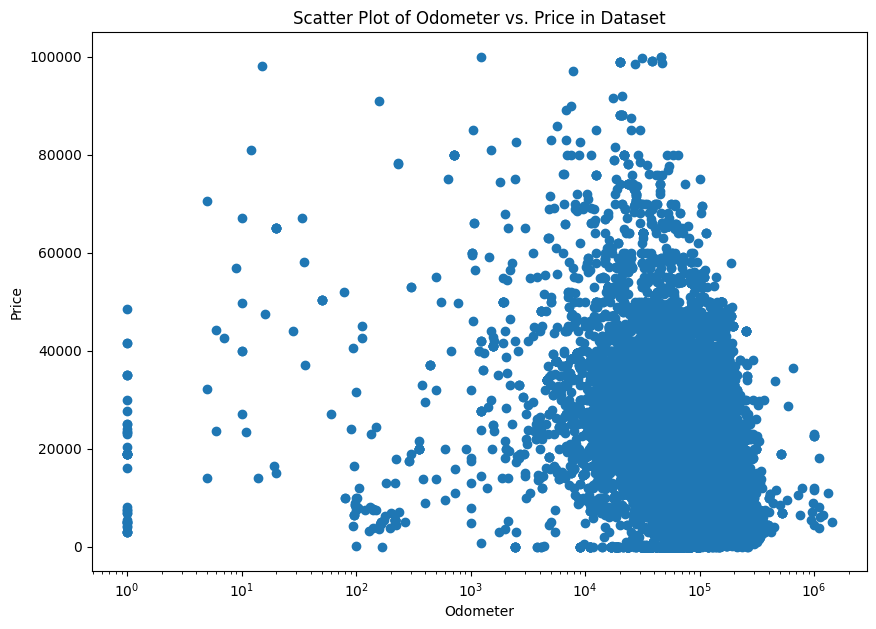

In [29]:
# Let's try a scatter plot of price vs odomoter to see if there is a Trend. Usually the lower the odometer, the higher the car price
fig, ax = plt.subplots(figsize=(10,7))
plt.xscale("log") 
ax.scatter(data['odometer'], data['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

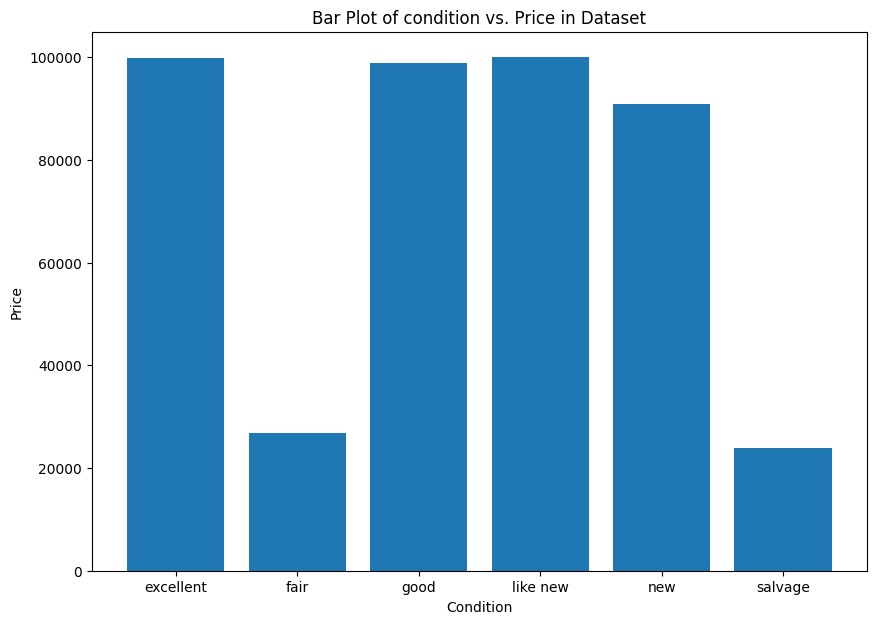

In [30]:
# Let's try a bar plot of price vs car's condition to see if there is a Trend. Usually the better the condition, the higher the car price
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(data['condition'], data['price'])
# set a title and labels
ax.set_title('Bar Plot of condition vs. Price in Dataset')
ax.set_xlabel('Condition')
ax.set_ylabel('Price')
plt.show()

### B. Year Outliers 

In [31]:
data['year'].value_counts().sort_values(ascending=True)

year
1931.0       1
1936.0       1
1959.0       1
2022.0       1
1939.0       1
          ... 
2012.0    2333
2016.0    2344
2014.0    2592
2015.0    2639
2013.0    2815
Name: count, Length: 88, dtype: int64

/var/folders/z_/9p038pkx1n9_c5jbhhjrbnmh0000gr/T/ipykernel_68160/447981138.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['year']).set(title = 'Distribution plot of year of used cars in the dataset')


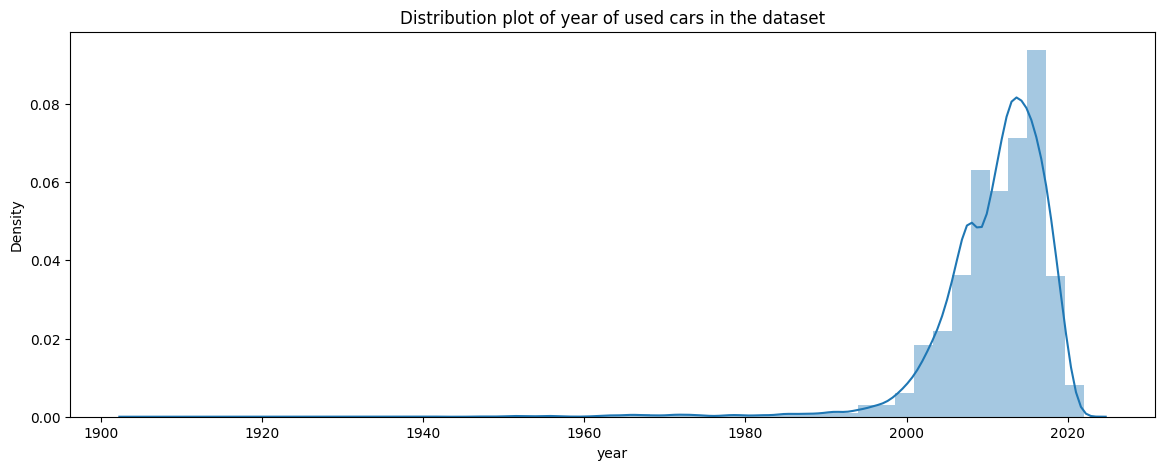

In [32]:
#Distribution plot of the year metrics
plt.figure(figsize=(14,5))
sns.distplot(data['year']).set(title = 'Distribution plot of year of used cars in the dataset')
plt.show()

In [33]:
# drop data for years less than 1995
data.drop(data[data['year'] < 1995].index, inplace = True)

In [34]:
data['year'].value_counts().sort_values(ascending=True)

year
2022.0       1
1995.0      61
2021.0      82
1997.0      97
1996.0      98
1998.0     139
1999.0     195
2000.0     264
2001.0     339
2002.0     454
2020.0     539
2003.0     607
2004.0     721
2005.0     946
2019.0    1097
2006.0    1200
2009.0    1329
2007.0    1540
2010.0    1625
2018.0    1639
2008.0    1837
2011.0    2052
2017.0    2127
2012.0    2333
2016.0    2344
2014.0    2592
2015.0    2639
2013.0    2815
Name: count, dtype: int64

/var/folders/z_/9p038pkx1n9_c5jbhhjrbnmh0000gr/T/ipykernel_68160/447981138.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['year']).set(title = 'Distribution plot of year of used cars in the dataset')


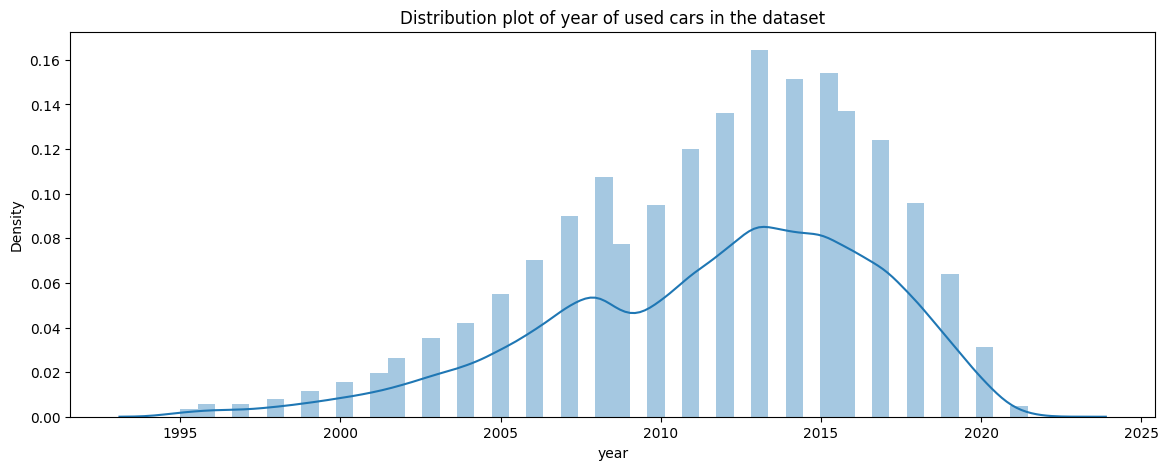

In [35]:
#Distribution plot of the year metrics
plt.figure(figsize=(14,5))
sns.distplot(data['year']).set(title = 'Distribution plot of year of used cars in the dataset')
plt.show()

[Text(0.5, 1.0, 'Box Plot of Year of used cars in the dataset after eliminating outliers')]

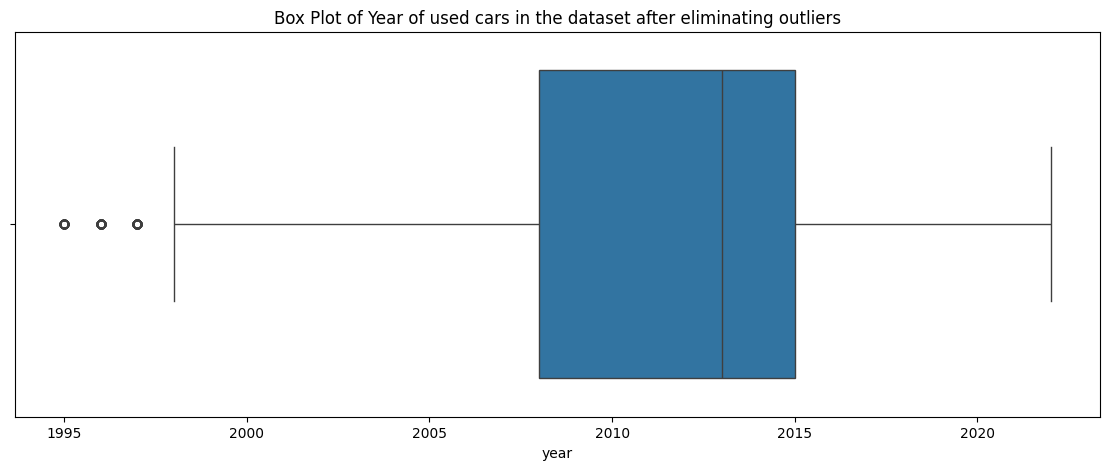

In [36]:
#box plot of 'Year' after outlier elimination
plt.figure(figsize=(14,5))
sns.boxplot(data=data,x='year').set(title="Box Plot of Year of used cars in the dataset after eliminating outliers")

### Using the figure and Boxplot, we can see that the bulk of outliers have been eliminated. Although the distribution is not normal, further iterations of this approach will yield marginal gains, therefore we will stop there for 'year' outliers.

In [37]:
data.shape

(31712, 15)

### Confirming NaN Values

In [40]:
# percentage of null values
data.isnull().sum()/data.shape[0]*100

price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
size            0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

## Data Understanding - Correlations and distribution of each feature.

In [41]:
data1 = data.copy()

In [42]:
#Sample of price, year, odometer, transmission and type
sample_data1 = data1[['price', 'year','odometer', 'transmission','type']]
sample_data1 = sample_data1.sample(n = 10000, random_state =1)
sample_data1

,price,year,odometer,transmission,type
386051,27990,2008.0,83459.0,automatic,truck
143610,11000,1999.0,48000.0,automatic,convertible
53499,12750,2002.0,178515.0,automatic,pickup
282228,38500,2017.0,74373.0,automatic,truck
388499,22995,2020.0,39663.0,automatic,SUV
...,...,...,...,...,...
285990,10990,2012.0,95426.0,automatic,convertible
350370,11100,2013.0,81600.0,automatic,SUV
738,31500,2019.0,24585.0,automatic,van
364488,4900,2008.0,163469.0,automatic,SUV


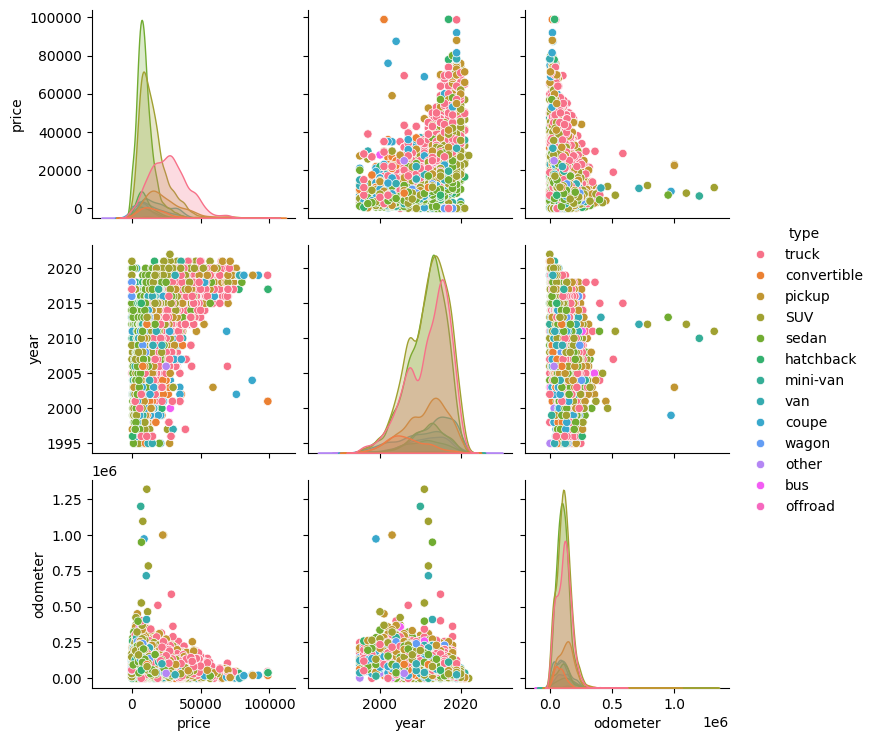

In [43]:
#Perform a pairplot
sns.pairplot(sample_data1, hue = 'type')

##### There is a positive correlation between price and year meaning new car has more value than the old cars. Similarly, there is a negative correlation between price and odometer which make sense as the vehicle will lose value if it was driven too much, and a slight negative correlation between odometer and year which depicts that old cars are more likely to be more driven.

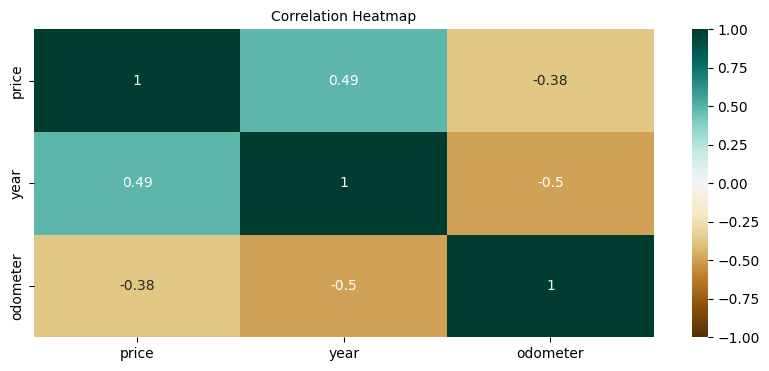

In [54]:
#correlation Heatmap
numeric_data = data1.select_dtypes(include=[np.number])  # Only select numeric columns
plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(numeric_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=6)
plt.show()

## Data Modeling
#### To begin with, perform a linear regression, polynomial of degree 2. To decide on the best model,review the MSE, MAE and Score/r^2 of each model.

### Linear Regression

In [69]:
from sklearn.impute import SimpleImputer

In [70]:
#Create a pipeline for the linear regression
X = data1.drop(columns = ['price'])
y = data1['price']

# Define categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer to handle categorical and numerical data preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('nums', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handling missing numerical data
            ('scaler', StandardScaler())]), numeric_cols),
        ('cats', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handling missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Define the complete pipeline
Linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Perform Linear regression on the data
Linear_pipeline.fit(X_train, y_train)
train_predict = Linear_pipeline.predict(X_train)
test_predict = Linear_pipeline.predict(X_test)

# Regression Error
Linear_train_mse = mean_squared_error(y_train, train_predict)
Linear_test_mse = mean_squared_error(y_test, test_predict)
Linear_train_mae = mean_absolute_error(y_train, train_predict)
Linear_test_mae = mean_absolute_error(y_test, test_predict)

# Output
linear_coefs = Linear_pipeline.named_steps['linear'].coef_
print(linear_coefs)

print(f"Linear Model: train_mse={Linear_train_mse}, test_mse={Linear_test_mse}")
print(f"Linear Model: train_mae={Linear_train_mae}, test_mae={Linear_test_mae}")
print(f"Model Score: {Linear_pipeline.score(X_test, y_test)}")

[ 5606.74018541 -2844.590833   -3378.05145943 ...  -516.5198239
  -679.94506098  1407.41698123]
Linear Model: train_mse=24276228.265629325, test_mse=34729255.00822768
Linear Model: train_mae=2999.8126116453677, test_mae=3724.606266568252
Model Score: 0.7850663634222448


In [73]:
#Create a pipeline for the polynomial regression
X = data1.drop(columns = ['price'])
y = data1['price']

# Define categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer to handle categorical and numerical data preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('nums', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handling missing numerical data
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Adding polynomial features
        ]), numeric_cols),
        ('cats', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handling missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Define the complete pipeline
Polynomial_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the polynomial regression model
Polynomial_pipeline.fit(X_train, y_train)
train_predict = Polynomial_pipeline.predict(X_train)
test_predict = Polynomial_pipeline.predict(X_test)

# Calculate regression errors
Polynomial_train_mse = mean_squared_error(y_train, train_predict)
Polynomial_test_mse = mean_squared_error(y_test, test_predict)
Polynomial_train_mae = mean_absolute_error(y_train, train_predict)
Polynomial_test_mae = mean_absolute_error(y_test, test_predict)

# Output results
print(Polynomial_pipeline)
print(f"Polynomial Model Degree 2: train_mse={Polynomial_train_mse}, test_mse={Polynomial_test_mse}")
print(f"Polynomial Model Degree 2: train_mae={Polynomial_train_mae}, test_mae={Polynomial_test_mae}")
print(f"Model Score Degree 2: {Polynomial_pipeline.score(X_test, y_test)}")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['year', 'odometer'], dtype='object')),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                               

In [74]:
#Create a pipeline for the polynomial regression - degree 3
X = data1.drop(columns = ['price'])
y = data1['price']

# Define categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer to handle categorical and numerical data preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('nums', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handling missing numerical data
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Adding polynomial features
        ]), numeric_cols),
        ('cats', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handling missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Define the complete pipeline
Polynomial_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the polynomial regression model
Polynomial_pipeline.fit(X_train, y_train)
train_predict = Polynomial_pipeline.predict(X_train)
test_predict = Polynomial_pipeline.predict(X_test)

# Calculate regression errors
Polynomial_train_mse = mean_squared_error(y_train, train_predict)
Polynomial_test_mse = mean_squared_error(y_test, test_predict)
Polynomial_train_mae = mean_absolute_error(y_train, train_predict)
Polynomial_test_mae = mean_absolute_error(y_test, test_predict)

# Output results
print(Polynomial_pipeline)
print(f"Polynomial Model Degree 3: train_mse={Polynomial_train_mse}, test_mse={Polynomial_test_mse}")
print(f"Polynomial Model Degree 3: train_mae={Polynomial_train_mae}, test_mae={Polynomial_test_mae}")
print(f"Model Score Degree 3: {Polynomial_pipeline.score(X_test, y_test)}")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  Index(['year', 'odometer'], dtype='object')),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim

##### I will stop at degree 3 because difference in MAE for each increase in polynomial is becoming less important. Hence, a polynomial of degree 2 or 3 seem to be optimal. The models with 2 and 3 degree polynomial are capable of capturing 81.5% and 81.6% of the variation in price.

### Cross-validation of models

In [76]:
# Create a column transformer to handle categorical and numerical data preprocessing
preprocessor3 = ColumnTransformer(
    transformers=[
        ('nums', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handling missing numerical data
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Adding polynomial features
        ]), numeric_cols),
        ('cats', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handling missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Define the complete pipeline
Poly3_pipeline = Pipeline([
    ('preprocessor', preprocessor3),
    ('linear', LinearRegression())
])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the polynomial regression model
Poly3 = Poly3_pipeline.fit(X_train, y_train)

# Permutation importance
feature_importance_poly3 = {}
r = permutation_importance(Poly3, X_test, y_test , n_repeats=30,random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
        f"  {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        feature_importance_poly3[X_test.columns[i]]=r.importances_mean[i]


year      0.371 +/- 0.008
model     0.316 +/- 0.006
odometer  0.113 +/- 0.003
manufacturer  0.107 +/- 0.002
fuel      0.065 +/- 0.002
type      0.064 +/- 0.002
transmission  0.028 +/- 0.001
state     0.016 +/- 0.001
cylinders  0.015 +/- 0.001
drive     0.010 +/- 0.001
title_status  0.007 +/- 0.001
size      0.003 +/- 0.000
paint_color  0.002 +/- 0.000
condition  0.002 +/- 0.000


In [84]:
df_feature_importance = pd.DataFrame(list(feature_importance_poly3.items()))
df_feature_importance .set_index(df_feature_importance .columns[0], inplace=True)
df_feature_importance 

,1
0,
year,0.370756
model,0.315500
odometer,0.112907
manufacturer,0.107389
fuel,0.065411
type,0.064207
transmission,0.027713
state,0.016031
cylinders,0.015296


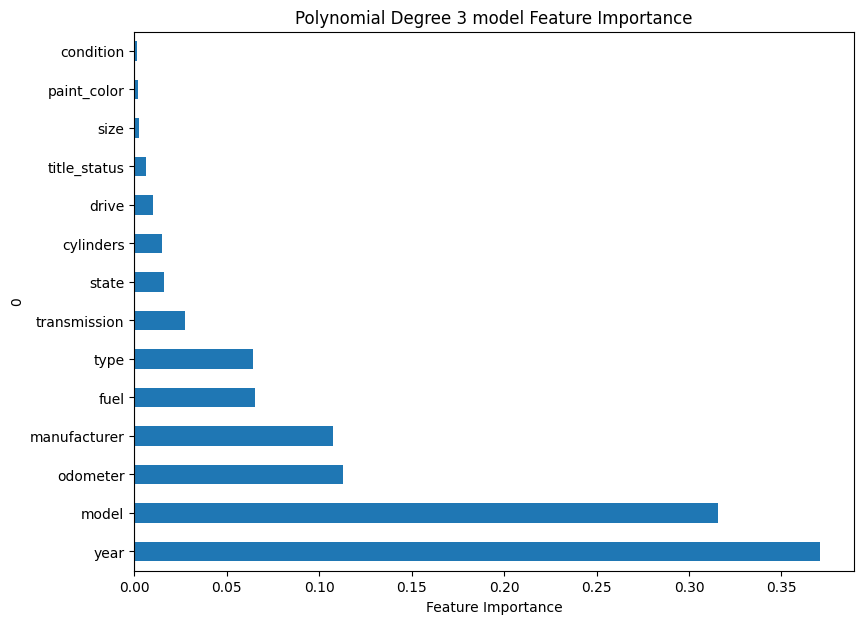

In [89]:
#Plot Feature importance
df_feature_importance.plot(kind='barh', figsize=(12, 7), legend =False )
plt.title("Polynomial Degree 3 model Feature Importance")
plt.axvline(x=0, color=".5")
plt.xlabel("Feature Importance")
plt.subplots_adjust(left=0.3)

#### 'Year' was by far the best feature to predict the price variation, other variables which impacted the price were model, odometer, manufacturer and fuel.